# IMDB Analysis

#### Objective: finding out which factors influence movie sucessfullness using Random Forest Regressor

**Data source:**
* IMDB databases in csv format
* IMDB website (scrapped)

**Steps:**
1. Data cleansing
2. Scrapping additional data
3. Further data cleansing
4. Finding correlativity
5. Predictions with Random Forest
6. Finding importance of factors
7. Final notes

In [1]:
import pandas as pd
import numpy as np
import re
import requests
from functools import reduce
from sklearn import preprocessing
from bs4 import BeautifulSoup, SoupStrainer
import urllib.request
from ipywidgets import FloatProgress
from IPython.display import display
from currency_converter import CurrencyConverter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
columnsSkip = ['originalTitle','endYear'] # skipping columns which will not be used in the analysis
movies = pd.read_csv('./docsy/dataBasics.csv', usecols=lambda x: x not in columnsSkip, sep='\t', low_memory=False)

In [3]:
movies.head()

,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,0,1894,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,0,1892,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,0,1892,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,0,1892,\N,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,0,1893,1,"Comedy,Short"


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6041205 entries, 0 to 6041204
Data columns (total 7 columns):
tconst            object
titleType         object
primaryTitle      object
isAdult           int64
startYear         object
runtimeMinutes    object
genres            object
dtypes: int64(1), object(6)
memory usage: 322.6+ MB


## 1. Data Cleansing

First, the Nans will be handled and the data will be converted into proper types.

'isAdult' can be only true or false:

In [5]:
movies['isAdult'] = movies['isAdult'].astype('bool')

Replacing \N with np.nan in order to use ffil method for missing year values.

In [6]:
movies['startYear'] = movies['startYear'].replace('\\N', np.nan)
movies['startYear'].fillna(method ='ffill', inplace = True) 
movies['startYear'] = movies['startYear'].astype('int')

Identifying non-digital values in runtimeMinutes:

In [7]:
movies['runtimeMinutes'].where(movies['runtimeMinutes'].str.contains('\D')).value_counts()

\N                        4238682
Reality-TV                      3
Animation,Comedy,Drama          1
Animation,Family                1
Name: runtimeMinutes, dtype: int64

Some values in 'runtimeMinutes' are being mixed with 'genres'. Those values need to be moved to the next column.

In [8]:
movies.loc[(movies.runtimeMinutes != '\\N') & (movies.runtimeMinutes.str.contains('\D')==True),'genres'] = movies['runtimeMinutes']

In turn, the missing values in runtimeMinutes will be filled by the mean runtime.

In order to do so, first the non-digits will be converted to np.nan and the values will be converted to float.

In [9]:
movies.loc[(movies.runtimeMinutes.str.contains('\D')==True),'runtimeMinutes'] = np.nan

In [10]:
movies['runtimeMinutes'] = movies['runtimeMinutes'].astype('float')

Based on whether movie is categorized as 'short', the average will be calculated using the values of the same kind.

In [11]:
shortMean = movies['runtimeMinutes'].loc[(movies.genres.str.contains('Short')==True)].mean()

In [12]:
longMean = movies['runtimeMinutes'].loc[(movies.genres.str.contains('Short')==False)].mean()

In [13]:
indicesTrue = (movies.genres.str.contains('Short')==True)
indicesFalse = (movies.genres.str.contains('Short')==False)

Filling the missing values:

In [14]:
movies.loc[indicesTrue,'runtimeMinutes'] = movies.loc[indicesTrue,'runtimeMinutes'].fillna(shortMean)

In [15]:
movies.loc[indicesFalse,'runtimeMinutes'] = movies.loc[indicesFalse,'runtimeMinutes'].fillna(longMean)

Filling the rest of missing values, which do not fall into above categories:

In [16]:
movies['runtimeMinutes'].fillna(0, inplace=True)

Finally, the values can be converted to int

In [17]:
movies['runtimeMinutes'] = movies['runtimeMinutes'].round()

In [18]:
movies['runtimeMinutes'] = movies['runtimeMinutes'].astype(int)

Since multiple genres are being stored in one column, they will be separated and stored into three separate colums.

First, the string will be splited and expanded into columns using **expand = True** and then assigned to dataframe.

In [19]:
genresArr = movies['genres'].str.split(',', expand = True)

In [20]:
movies['genreFirst'] = genresArr[0]
movies['genreSecond'] = genresArr[1]
movies['genreThird'] = genresArr[2]

Original 'genres' column can be dropped now

In [21]:
movies.drop(columns =['genres'], inplace = True)

Replacing empty values with string 'None'

In [22]:
movies.replace([None], 'None', inplace=True)
movies['genreFirst'] = movies['genreFirst'].replace('\\N', 'None')

Converting genres and title type into categorical data:

In [23]:
movies['genreFirst'] = movies['genreFirst'].astype('category')
movies['genreSecond'] = movies['genreSecond'].astype('category')
movies['genreThird'] = movies['genreThird'].astype('category')
movies['titleType'] = movies['titleType'].astype('category')

Currently, the dtypes look as follows:

In [24]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6041205 entries, 0 to 6041204
Data columns (total 9 columns):
tconst            object
titleType         category
primaryTitle      object
isAdult           bool
startYear         int32
runtimeMinutes    int32
genreFirst        category
genreSecond       category
genreThird        category
dtypes: bool(1), category(4), int32(2), object(2)
memory usage: 167.1+ MB


After loading, ratings will be merged on **'tconst'**

In [25]:
ratings = pd.read_csv('./docsy/dataRating.csv', sep='\t', low_memory=False)

In [26]:
movies = pd.merge(movies, ratings, on='tconst')

In [27]:
movies.head()

,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genreFirst,genreSecond,genreThird,averageRating,numVotes
0,tt0000001,short,Carmencita,False,1894,1,Documentary,Short,None,5.8,1524
1,tt0000002,short,Le clown et ses chiens,False,1892,5,Animation,Short,None,6.3,185
2,tt0000003,short,Pauvre Pierrot,False,1892,4,Animation,Comedy,Romance,6.6,1171
3,tt0000004,short,Un bon bock,False,1892,13,Animation,Short,None,6.3,113
4,tt0000005,short,Blacksmith Scene,False,1893,1,Comedy,Short,None,6.2,1884


In [28]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 956735 entries, 0 to 956734
Data columns (total 11 columns):
tconst            956735 non-null object
titleType         956735 non-null category
primaryTitle      956735 non-null object
isAdult           956735 non-null bool
startYear         956735 non-null int32
runtimeMinutes    956735 non-null int32
genreFirst        956735 non-null category
genreSecond       956735 non-null category
genreThird        956735 non-null category
averageRating     956735 non-null float64
numVotes          956735 non-null int64
dtypes: bool(1), category(4), float64(1), int32(2), int64(1), object(2)
memory usage: 48.4+ MB


The popularity value will be calculated based on number of votes.

First, values will be standarized on scale from 0 to 100:

In [29]:
votes = movies['numVotes'].values.reshape(-1, 1)

In [30]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 100))

In [31]:
standarized = scaler.fit_transform(votes)

C:\Users\Natalia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [32]:
standarized = standarized.flatten()

In [33]:
standarized = np.round(standarized, 2)

In [34]:
standarized = pd.Series(standarized)

In [35]:
movies['popularity'] = standarized

The popularity will have 5 values, based on categories generated by bins of value_counts

In [36]:
movies['popularity'].value_counts(bins=5)

(-0.101, 20.0]    956469
(20.0, 40.0]         212
(40.0, 60.0]          39
(60.0, 80.0]          12
(80.0, 100.0]          3
Name: popularity, dtype: int64

In [37]:
conditions = [
    movies['popularity'] < 20,
    (movies['popularity'] >= 20) & (movies['popularity'] < 40),
    (movies['popularity'] >= 40) & (movies['popularity'] < 60),
    (movies['popularity'] >= 60) & (movies['popularity'] < 80),
    movies['popularity'] > 80,
]

values = [1, 2, 3, 4, 5]

In [38]:
movies['popularity'] = np.select(conditions, values, default='1')
movies['popularity'] = movies['popularity'].astype(int)
movies['score'] = movies['popularity'] * movies['averageRating']

In [39]:
movies.head()

,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genreFirst,genreSecond,genreThird,averageRating,numVotes,popularity,score
0,tt0000001,short,Carmencita,False,1894,1,Documentary,Short,None,5.8,1524,1,5.8
1,tt0000002,short,Le clown et ses chiens,False,1892,5,Animation,Short,None,6.3,185,1,6.3
2,tt0000003,short,Pauvre Pierrot,False,1892,4,Animation,Comedy,Romance,6.6,1171,1,6.6
3,tt0000004,short,Un bon bock,False,1892,13,Animation,Short,None,6.3,113,1,6.3
4,tt0000005,short,Blacksmith Scene,False,1893,1,Comedy,Short,None,6.2,1884,1,6.2


## 2. Scrapping additional data

As the numbers of won Oscars, Oscars nominations and budget are not included in the already prepared databases, they need to be scrapped from the website. 

Since the row count would be too large to process with BeautifulSoup in reasonable time, 10000 most and least succesfull movies from 1950 and onwards will be used in further analysis.

In [40]:
topMovies = movies.where((movies['startYear']>1950) & (movies['titleType'] == 'movie')).nlargest(10000, 'score')

In [41]:
bottomMovies = movies.where((movies['startYear']>1950) & (movies['titleType'] == 'movie')).nsmallest(10000, 'score')

In [42]:
topArr = topMovies['tconst'].values 
bottomArr =  bottomMovies['tconst'].values
tconstArr = np.concatenate((topArr, bottomArr))

Scrapping the data and saving it into csv file for easy access in the future:

In [43]:
# countryList = []
# budgetList = []
# oscarsWinList = []
# oscarsNomList =[]

# divTags = SoupStrainer('div',{'class': 'txt-block'})

# f = FloatProgress(min=0, max=20000)
# display(f)
        
# for i, t in enumerate(tconstArr):
    
#     response = requests.get('https://www.imdb.com/title/'+t)
    
#     if response.status_code == 200:
        
#         oscarsNominee = 0
#         oscarsWinner = 0
        
#         page = urllib.request.urlopen('https://www.imdb.com/title/'+t)
#         pageAwards = urllib.request.urlopen('https://www.imdb.com/title/'+t+'/awards')
        
#         soup = BeautifulSoup(page,parse_only=divTags)
#         allH = soup.findAll('h4')
    
#         soupAwards = BeautifulSoup(pageAwards)
        
#         if (soupAwards.find('table', {'class':'awards'})):
#             table = soupAwards.find('table', {'class':'awards'}) #Oscars, if any, always appear first on awards page, so no findAll needed - only first element.
#             awardsTd = table.findAll('td', {'class':'title_award_outcome'})

#             for td in awardsTd:
#                 b = td.find('b')
#                 if ((b.text.strip() == 'Winner')&(b.findNext('span').text=='Oscar')):
#                     oscarsWinner = td.get('rowspan')
#                 elif ((b.text.strip() == 'Nominee')&(b.findNext('span').text=='Oscar')):
#                     oscarsNominee = td.get('rowspan')


#         for h in allH:
#             if (h.text.strip() == 'Country:'):
#                 countryList.append(h.findNext('a').text.strip())
#             elif (h.text.strip() == 'Budget:'):
#                 budgetList.append(h.nextSibling.string.strip())

#         try:
#             countryList[i]
#         except:
#             countryList.append(np.nan)
            
#         try:
#             budgetList[i]
#         except:
#             budgetList.append(0)
            
#         oscarsWinList.append(oscarsWinner)
#         oscarsNomList.append(oscarsNominee)
#         f.value += 1
        
#     else:
#         print(t + ' was not found. Deleting...')
#         tconstArr = np.delete(tconstArr, np.where(tconstArr == t))
#         budgetList = np.delete(budgetList, np.where(tconstArr == t))
#         countryList = np.delete(countryList, np.where(tconstArr == t))
#         f.value += 1
        
# df=pd.DataFrame(tconstArr,columns=['tconst'])
# df['orginCountry'] = countryList
# df['budget'] = budgetList
# df['oscarsWin'] = oscarsWinList
# df['oscarsNom'] = oscarsNomList
# df.to_csv('dataAdd.csv')

## 3. Further data cleansing

The newly obtained data is being incorporated into the selected movies database.

In [44]:
columnsSkip = ['Unnamed: 0']
df = pd.read_csv('dataAdd.csv', usecols=lambda x: x not in columnsSkip)
df.head()

,tconst,orginCountry,budget,oscarsWin,oscarsNom
0,tt0111161,USA,"$25,000,000",0,7
1,tt0468569,USA,"$185,000,000",2,6
2,tt1375666,USA,"$160,000,000",4,4
3,tt0068646,USA,"$6,000,000",3,8
4,tt0110912,USA,"$8,000,000",1,6


In [45]:
moviesSelect = pd.concat([topMovies, bottomMovies])

In [46]:
moviesSelect = pd.merge(moviesSelect, df, on='tconst')

In [47]:
moviesSelect.head()

,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genreFirst,genreSecond,genreThird,averageRating,numVotes,popularity,score,orginCountry,budget,oscarsWin,oscarsNom
0,tt0111161,movie,The Shawshank Redemption,0.0,1994.0,142.0,Drama,None,None,9.3,2117204.0,5.0,46.5,USA,"$25,000,000",0,7
1,tt0468569,movie,The Dark Knight,0.0,2008.0,152.0,Action,Crime,Drama,9.0,2082865.0,5.0,45.0,USA,"$185,000,000",2,6
2,tt1375666,movie,Inception,0.0,2010.0,148.0,Action,Adventure,Sci-Fi,8.8,1856206.0,5.0,44.0,USA,"$160,000,000",4,4
3,tt0068646,movie,The Godfather,0.0,1972.0,175.0,Crime,Drama,None,9.2,1453649.0,4.0,36.8,USA,"$6,000,000",3,8
4,tt0110912,movie,Pulp Fiction,0.0,1994.0,154.0,Crime,Drama,None,8.9,1656371.0,4.0,35.6,USA,"$8,000,000",1,6


Filling Nans in orginCountry column:

In [48]:
moviesSelect['orginCountry'].fillna('None', inplace=True)

Upon inspecting 'budget' column it seems that not every value is shown in dollars.

In [49]:
moviesSelect['budget'].str.findall('\D+').str[0].value_counts().head(10)

$       3584
€        481
£        320
INR      198
CAD      188
AUD       99
RUR       61
SEK       41
NOK       29
BRL       27
Name: budget, dtype: int64

The budget will be converted to USD using currency converter.

First three entries can be easily recognized:

In [50]:
currDict = {'$':'USD', '£':'GBP', '€':'EUR'}

for key in currDict.keys():
    moviesSelect['budget'] = moviesSelect['budget'].str.replace(key, currDict[key])

Some values are empty, since budget have been scrapped as 0, due to it not being provided on the website.

The empty values will be changed to 0 for now.

In [51]:
currArr = moviesSelect['budget'].str.replace(',','').str.findall('\D+[A-Z]').str[0]
valArr = moviesSelect['budget'].str.replace('\D','').astype(float)
currArrZero = []

It may happen that some currencies are not being supported by currency converter. 

Those can be easily detected by checking if the value does not appear on **c.currencies** list.

In [52]:
for curr in currArr:
    currArrZero.append(np.nan_to_num(curr))

In [53]:
c = CurrencyConverter()
unsupported = []
for i in range(0,19997):
    if (currArrZero[i] not in c.currencies)&(currArrZero[i] != 0):
        unsupported.append(currArrZero[i])

The duplicates will be removed in order to fetch the conversion rate for dollar from <http://exchangerate.com/>.

In [54]:
unsupported = np.unique(unsupported)
unsupportedExg = []

In [55]:
tdTags = SoupStrainer('b')
for unsup in unsupported:
    page = urllib.request.urlopen('http://www.exchangerate.com/currency-converter/USD/'+unsup)
    soup = BeautifulSoup(page,parse_only=tdTags)
    allB = soup.findAll('b')
    exg = float(allB[11].text)
    exg = np.format_float_positional(exg)
    unsupportedExg.append(exg)

Now, budget will be converted to USD by currency converter, previously scrapped data or it will simply be 0, based on the type of currency the original value.

In [56]:
newValArr = []

for i in range(0,19997):
    if (currArrZero[i] == 0):
        newValArr.append(0)
    elif ((currArrZero[i] not in c.currencies)&(currArrZero[i] != 0)):
        newValArr.append(int(valArr[i]*(float(unsupportedExg[np.where(unsupported == currArrZero[i])[0][0]]))))
    else:
        newValArr.append(int(c.convert(valArr[i], currArrZero[i], 'USD')))

In [57]:
moviesSelect['budget'] = newValArr
moviesSelect.rename(columns={'budget':'budgetUSD'}, inplace=True)

As the database is ready to be encoded and used for predictions, the values can be converted into ints and bools where possible.

In [58]:
moviesSelect['tconst'] = moviesSelect['tconst'].str.replace('\D','')
moviesSelect['tconst'] = moviesSelect['tconst'].astype(int)

In [59]:
moviesSelect['oscarsWin'] = moviesSelect['oscarsWin'].astype(int)
moviesSelect['oscarsNom'] = moviesSelect['oscarsNom'].astype(int)

In [60]:
moviesSelect['startYear'] = moviesSelect['startYear'].astype(int)
moviesSelect['runtimeMinutes'] = moviesSelect['runtimeMinutes'].astype(int)
moviesSelect['numVotes'] = moviesSelect['numVotes'].astype(int)
moviesSelect['score'] = moviesSelect['score'].astype(int)
moviesSelect['averageRating'] = moviesSelect['averageRating'].astype(int)
moviesSelect['popularity'] = moviesSelect['popularity'].astype(int)
moviesSelect['isAdult'] = moviesSelect['isAdult'].astype(bool)
moviesSelect['budgetUSD'] = moviesSelect['budgetUSD'].astype(int)

In [61]:
moviesSelect.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19997 entries, 0 to 19996
Data columns (total 17 columns):
tconst            19997 non-null int32
titleType         19997 non-null category
primaryTitle      19997 non-null object
isAdult           19997 non-null bool
startYear         19997 non-null int32
runtimeMinutes    19997 non-null int32
genreFirst        19997 non-null category
genreSecond       19997 non-null category
genreThird        19997 non-null category
averageRating     19997 non-null int32
numVotes          19997 non-null int32
popularity        19997 non-null int32
score             19997 non-null int32
orginCountry      19997 non-null object
budgetUSD         19997 non-null int32
oscarsWin         19997 non-null int32
oscarsNom         19997 non-null int32
dtypes: bool(1), category(4), int32(10), object(2)
memory usage: 1.3+ MB


Finally, the rest of data can be label encoded.

In [62]:
moviesSelectEnc = moviesSelect.apply(LabelEncoder().fit_transform)

In [63]:
moviesSelectEnc.drop(['titleType','primaryTitle', 'genreSecond', 'genreThird'],axis=1, inplace=True)

In [64]:
moviesSelectEnc.head()

,tconst,isAdult,startYear,runtimeMinutes,genreFirst,averageRating,numVotes,popularity,score,orginCountry,budgetUSD,oscarsWin,oscarsNom
0,1796,0,43,138,8,6,2211,4,23,149,1214,0,7
1,6680,0,57,148,0,6,2210,4,22,149,1288,2,6
2,8976,0,59,144,0,5,2209,4,21,149,1282,4,4
3,588,0,21,171,6,6,2202,3,20,149,1140,3,8
4,1785,0,43,150,6,5,2207,3,19,149,1160,1,6


## 4. Finding correlativity

The correlativity of data can be presented using heatmap.

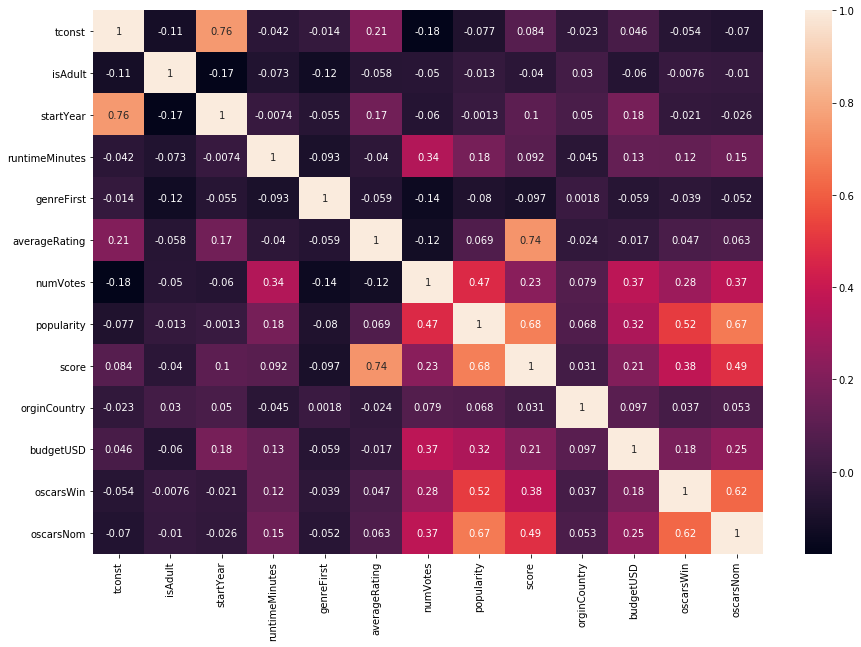

In [65]:
corr = moviesSelectEnc.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True)
heat_map=plt.gcf()
heat_map.set_size_inches(15,10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

From the above graph it can be concluded that: 

* The budget influences popularity of a movie;
* Oscars won and Oscars nominations are related to popularity;
* Number of votes is slightly related to runtime minutes of a movie.

## 5. Predictions with Random Forest

As the score is calculated from averageRating and popularity (numVotes), it is clear that those columns need to be excluded from the data. 

In [66]:
labels = np.array(moviesSelectEnc['score']) #the value to be predicted
features = moviesSelectEnc.drop(['averageRating', 'score', 'popularity', 'numVotes', 'tconst'], axis=1) #features to be excluded
features = np.array(features)
features_list = list(moviesSelectEnc.drop(['averageRating', 'score', 'popularity', 'numVotes', 'tconst'], axis=1))

Now, the data can be split into train and test sets - the size of the sets will be 75:25.

In [67]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

Making predictions using 50 estimators:

In [68]:
reg = RandomForestRegressor(n_estimators = 50, random_state = 42)
reg.fit(train_features, train_labels)
predictions = reg.predict(test_features)

In order to calculate the effectiveness of the predictions, the mean error will be calculated by using predictions and actual values.

In [69]:
errors = abs(predictions - test_labels)
print('Error:', round(np.mean(errors), 2))

Error: 0.66


Predicted values can be compared with actual values and analysed further.

In [70]:
predictCompare = pd.DataFrame()
predictCompare['scoreActual'] = test_labels
predictCompare['scorePredicted'] = predictions
predictCompare['error'] = abs(test_labels - predictions)

In [71]:
predictCompare.head()

,scoreActual,scorePredicted,error
0,0,1.920000,1.920000
1,3,1.960000,1.040000
2,3,3.140000,0.140000
3,3,3.156667,0.156667
4,2,1.360000,0.640000


In [72]:
predictCompare.where(predictCompare['error'] == predictCompare['error'].max()).dropna()

,scoreActual,scorePredicted,error
3146,23.0,12.18,10.82


In [73]:
predictCompare.where(predictCompare['scoreActual'] == predictCompare['scoreActual'].max()).dropna()

,scoreActual,scorePredicted,error
3146,23.0,12.18,10.82


## 6. Finding importance of factors

Based on the random forest classifier predictions, the importance of features used in predictions can be established.

The top 5 features look as follows:

In [74]:
movies_f = pd.DataFrame(reg.feature_importances_, columns=['impact'])
movies_f['features'] = features_list
movies_f.sort_values('impact', inplace=True, ascending=False)
display(movies_f.head())

,impact,features
7,0.236399,oscarsNom
5,0.186184,budgetUSD
3,0.167705,genreFirst
2,0.157076,runtimeMinutes
1,0.135544,startYear


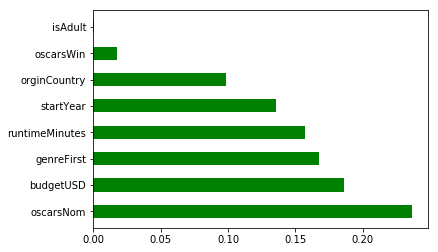

In [75]:
index = np.arange(len(reg.feature_importances_))
bar_width = 0.5
rects = plt.barh(index , movies_f['impact'], bar_width, alpha=1, color='g', label='Main')
plt.yticks(index, movies_f['features'])
plt.show()

## 6. Final notes

The algorythm can be further improved by collecting and incorporating more data, such as popularity of actors starring or directors being resposible for the titles. 

The top factors influencing the successfullness of a movie are:

* runtime minutes
* year of production
* genre
* country of orgin
* budget

Suprisingly, the budget used does not assure the success, regardless, it still strongly influences whether the movie will be popular and perceived well.